<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 09/10 - Avaliação de Modelos de Difusão e Projeto Final: Geração e Exportação**

Na aula passada, construímos diversos modelos de difusão. Agora, vamos realizar o projeto completo: avaliar os resultados obtidos, aplicar métricas quantitativas ao longo do treinamento e, por fim, gerar toda a estrutura de MLOps para execução e deploy do modelo.

## **Avaliação de modelos de difussão**

A avaliação de modelos de difusão apresenta desafios específicos que diferem significativamente das métricas tradicionais utilizadas em tarefas supervisionadas. Enquanto em tarefas de classificação podemos medir métricas como precisão, recall e F1-score ao comparar predições com rótulos verdadeiros, em modelos generativos é necessário avaliar aspectos como qualidade, diversidade e fidelidade das amostras geradas.

Os modelos de difusão, são mais complexos de avaliar, pois aprendem a reverter um processo de adição de ruído para gerar dados sintéticos.

## **Configurações iniciais**

In [1]:
# Instalar bibliotecas necessárias para avaliação
!pip install torch-fidelity -q
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 22.9 MB/s eta 0:00:00


In [1]:
# Bibliotecas padrão
import ast
import re
import math
import numpy as np
import textwrap
import kagglehub
import shutil
import os
import pandas as pd
from collections import defaultdict, Counter

# Bibliotecas de visualização
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Im2

# Bibliotecas PyTorch, torchvision, estatisticas e Visão Computacional
import cv2
import torch.nn as nn
import torch, torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils import clip_grad_norm_

from torchvision import transforms
from torchvision.models import inception_v3
from torchvision.utils import make_grid
from torchvision.transforms import v2

import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Baixar dataset
dataset_path = kagglehub.dataset_download("ashfakyeafi/brain-mri-images")

# Definir destino no /content
destination_path = '/content/brain-mri-images'

# Copiar para /content
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)
print("Dataset copiado para:", destination_path)

100%|██████████| 348M/348M [00:03<00:00, 106MB/s] 

Extracting files...


Dataset copiado para: /content/brain-mri-images


Desde a Aula 07, temos trabalhado com diferentes versões do nosso dataset. Agora vamos realizar mais um avanço importante: extrair automaticamente a descrição da classe através da análise do nome do arquivo, especificamente identificando se a imagem representa um corte axial, coronal ou sagittal do cérebro.
Esta melhoria nos permitirá ter labels mais semânticos e facilitará tanto o condicionamento quanto a interpretação dos resultados.

In [4]:
class Dataset(Dataset):
    def __init__(self, images_dir, transform=None, slice_plane=None):
        self.transform = transform
        self.slice_plane = slice_plane
        self.image_files = []
        self.labels = []
        self.label_to_idx = {}

        # Mapeamento das descrições das classes
        self.class_descriptions = {
            "z": "axial",
            "y": "coronal",
            "x": "sagittal"
        }

        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    parts = file.lower().split('_')
                    if len(parts) > 3:
                        plane = parts[3]
                        self.image_files.append(os.path.join(root, file))

                        label = plane  # Usando o plano como rótulo
                        if label not in self.label_to_idx:
                            self.label_to_idx[label] = len(self.label_to_idx)
                        self.labels.append(self.label_to_idx[label])

        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)

        print(f"Dataset carregado: {len(self.image_files)} imagens")
        print(f"Classes encontradas: {self.label_to_idx}")

        # Impressão da quantidade de amostras por classe (rótulo original)
        label_counts = Counter(self.labels)
        for idx, count in label_counts.items():
            plane_name = self.idx_to_label[idx]
            description = self.class_descriptions.get(plane_name, plane_name)
            print(f"Classe '{description}': {count} amostras")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path).lower()
        image = Image.open(img_path).convert('L')

        parts = img_name.split('_')
        slice_plane = parts[3]

        if self.transform:
            image = self.transform(image)

        # Obter a descrição da classe baseada no label
        label_idx = self.labels[idx]
        plane_name = self.idx_to_label[label_idx]
        class_description = self.class_descriptions.get(plane_name, plane_name)

        return {
            "image": image,
            "slice": slice_plane,
            "label": label_idx,
            "class_description": class_description,
            "plane_name": plane_name
        }

    def get_class_description(self, label_idx):
        plane_name = self.idx_to_label.get(label_idx, "unknown")
        return self.class_descriptions.get(plane_name, plane_name)

    def get_all_descriptions(self):
        descriptions = {}
        for idx, plane_name in self.idx_to_label.items():
            descriptions[idx] = self.class_descriptions.get(plane_name, plane_name)
        return descriptions

Agora vamos configurar nossos dados da mesma forma que fizemos nas aulas anteriores, mantendo a consistência no pré-processamento e na normalização para o range [-1, 1] que nossos modelos de difusão esperam.

In [5]:
# Definir Dimensão da Imagem
img_size = 64

# Transformação básica para normalizar para [-1,1]
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset e DataLoader
dataset = Dataset(
    '/content/brain-mri-images',
    transform=transform,
    slice_plane=None
    )

# Carrega dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Dataset carregado: 7692 imagens
Classes encontradas: {'y': 0, 'x': 1, 'z': 2}
Classe 'coronal': 2564 amostras
Classe 'sagittal': 2564 amostras
Classe 'axial': 2564 amostras


Visualizando 16 amostras do dataset


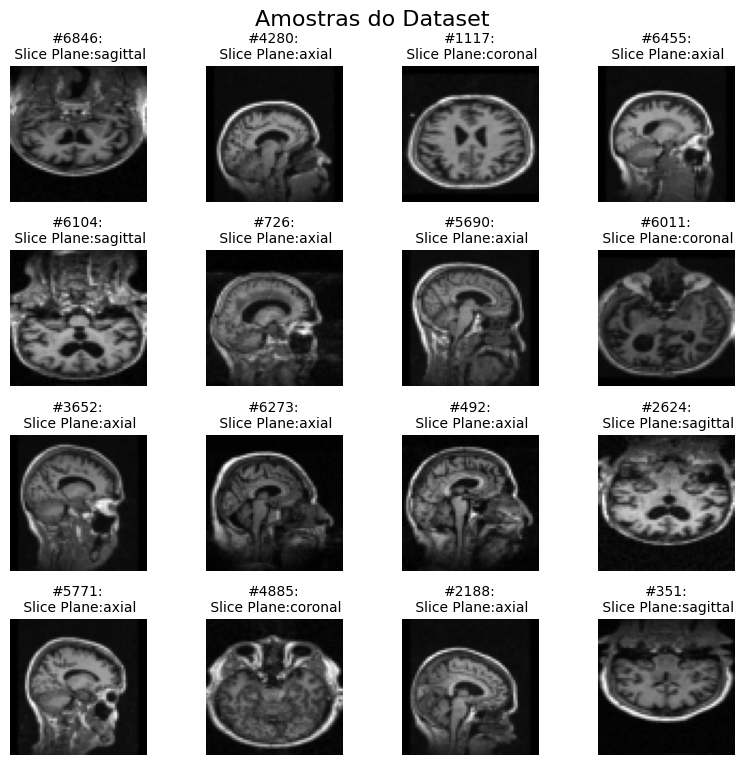

In [6]:
# Seleciona aleatoriamente até 16 índices do dataset
indices = np.random.choice(len(dataset), size=min(16, len(dataset)), replace=False)
print(f"Visualizando {len(indices)} amostras do dataset")

# Define grid para exibição: 8 colunas e número de linhas necessário
cols = 4
rows = (len(indices) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))

# Garante que axes tenha sempre shape 2D para facilitar o loop
axes = np.atleast_2d(axes)

# Itera sobre cada índice selecionado e plota no grid
for i, idx in enumerate(indices):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sample = dataset[idx]

    # Recupera imagem e label
    image = sample['image']
    class_description = sample['class_description']

    # Desnormaliza de [-1,1] para [0,1]
    img_vis = torch.clamp((image * 0.5) + 0.5, 0, 1)
    img_np = img_vis.permute(1, 2, 0).cpu().numpy()

    # Plota a imagem
    ax.imshow(img_np, cmap='gray')
    ax.axis('off')

    # Formata o texto do label em múltiplas linhas
    class_description = "\n".join(textwrap.wrap(str(class_description), width=10))
    ax.set_title(f"#{idx}:\n Slice Plane:{class_description}", fontsize=10, pad=5)

# Oculta subplots vazios
total_slots = rows * cols
for i in range(len(indices), total_slots):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

# Título geral do grid
plt.suptitle("Amostras do Dataset", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## **Métricas Quantitativas para Avaliação**

Agora chegamos a uma parte fundamental: como avaliar objetivamente a qualidade das imagens geradas por nossos modelos de difusão. Diferentemente de tarefas de classificação onde podemos simplesmente contar acertos e erros, em modelos generativos precisamos de métricas mais sofisticadas que capturam aspectos perceptuais e estatísticos da qualidade das imagens.

As métricas que vamos implementar não olham apenas para **pixels iguais**, mas para semelhanças estatísticas e perceptuais mais profundas, usando redes neurais pré-treinadas para extrair representações de alto nível das imagens.

### [**Fréchet Inception Distance (FID)**](https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html)
O FID é uma das métricas mais importantes para avaliar modelos generativos. Ela compara a distribuição das features das imagens reais com a das imagens geradas, usando uma rede neural já treinada ([InceptionV3](https://pytorch.org/hub/pytorch_vision_inception_v3/)) para extrair representações de alto nível das imagens (formas, padrões, texturas, não apenas cores).
Como funciona:

- Calcula a média e a covariância das features das imagens reais e geradas
- Compara essas duas distribuições assumindo que seguem distribuições Gaussianas
- Valores baixos do FID indicam que as imagens geradas são estatisticamente similares às reais


In [7]:
from torchmetrics.image.fid import FrechetInceptionDistance

class TorchMetricsFID:
    def __init__(self, device='cuda'):
        self.fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

    def update_real(self, images):
        images = self._prepare_images(images)
        self.fid.update(images, real=True)

    def update_fake(self, images):
        images = self._prepare_images(images)
        self.fid.update(images, real=False)

    def compute(self):
        return self.fid.compute().item()

    def reset(self):
        self.fid.reset()

    def _prepare_images(self, images):
        # Redimensionar para 299x299
        if images.shape[-1] != 299:
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

        # Grayscale para RGB
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        # Normalizar para [0,1]
        images = (images + 1) / 2.0
        return images



# Instanciar calculadora FID
fid_calculator = TorchMetricsFID(device=device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 311MB/s]


###  [**Inception Score (IS)**](https://lightning.ai/docs/torchmetrics/stable/image/inception_score.html#inception-score)

O IS também utiliza a InceptionV3, mas mede dois aspectos importantes:

- Qualidade: imagens boas geram predições com alta confiança (baixa entropia condicional)
- Diversidade: o conjunto de imagens geradas cobre várias classes (alta entropia marginal)

Em outras palavras, queremos que cada imagem individualmente pareça claramente com algo específico, mas que o conjunto todo tenha variedade.

In [8]:
from torchmetrics.image.inception import InceptionScore

class TorchMetricsIS:
    def __init__(self, device='cuda'):
        self.device = device
        self.is_metric = InceptionScore(splits=10, normalize=True).to(device)

    def update(self, images):
        images = self._prepare_images(images)
        self.is_metric.update(images)

    def compute(self):
        # Recupera valores com desvio corrigido
        mean, std = self.is_metric.compute()
        mean = mean.item()
        std = std.to(dtype=torch.float32).item() if std.numel() > 1 else 0.0
        return mean, std

    def reset(self):
        self.is_metric.reset()

    def _prepare_images(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        images = (images + 1) / 2.0
        return images

# Instanciar calculadora IS
calculate_inception_score = TorchMetricsIS(device=device)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### [**Learned Perceptual Image Patch Similarity (LPIPS)**](https://lightning.ai/docs/torchmetrics/stable/image/learned_perceptual_image_patch_similarity.html#learned-perceptual-image-patch-similarity-lpips)

O LPIPS completa nosso conjunto de métricas ao focar na similaridade perceptual entre imagens. Esta métrica é útil para comparar pares de imagens e determinar quão similares elas parecem aos olhos humanos, mesmo que tenham pequenas variações de cor ou posição

In [9]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

class TorchMetricsLPIPS:
    def __init__(self, net_type='vgg', device='cuda'):
        self.device = device
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type=net_type).to(device)

    def calculate_lpips(self, images1, images2):
        # Grayscale → RGB
        if images1.shape[1] == 1:
            images1 = images1.repeat(1, 3, 1, 1)
        if images2.shape[1] == 1:
            images2 = images2.repeat(1, 3, 1, 1)

        # Garantir normalização entre [-1, 1]
        images1 = torch.clamp(images1, -1.0, 1.0)
        images2 = torch.clamp(images2, -1.0, 1.0)

        with torch.no_grad():
            scores = self.lpips(images1, images2)

        mean = scores.mean().item()
        std = scores.std(unbiased=False).item() if scores.numel() > 1 else 0.0
        return mean, std

# Instanciar calculadora LPIPS
lpips_calculator = TorchMetricsLPIPS(device=device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 169MB/s]


## **Configuração do Modelo**

Agora que temos nossas métricas de avaliação prontas, vamos configurar nosso modelo de difusão condicional. Este modelo combina tudo que aprendemos ao longo do curso: arquitetura U-Net (Aulas 04-06), condicionamento por labels (Aula 07).

### **Embedding de Rótulos (Label Embedding)**

In [2]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)
        self.num_classes = num_classes

    def forward(self, labels):
        return self.embedding(labels)

### **Embedding temporal**

In [3]:
# Embedding senoidal de tempo
def sinusoidal_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device,
                                                      dtype=torch.float32) / (half - 1))
    emb = t[:, None].float() * freqs[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=1)

In [4]:
class ConditionalTimeEmbedding(nn.Module):
    def __init__(self, time_dim, label_dim):
        super().__init__()
        self.time_dim = time_dim
        self.label_dim = label_dim

        # MLP para processar embedding temporal
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # MLP para processar embedding de rótulo
        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, label_dim * 2),
            nn.SiLU(),
            nn.Linear(label_dim * 2, time_dim)
        )

        # Camada de fusão
        self.fusion = nn.Sequential(
            nn.Linear(time_dim * 2, time_dim),
            nn.SiLU()
        )

    def forward(self, t, label_emb):
        # Processar embedding temporal
        t_emb = sinusoidal_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        # Processar embedding de rótulo
        l_emb = self.label_mlp(label_emb)

        # Fusão dos embeddings
        combined = torch.cat([t_emb, l_emb], dim=1)
        return self.fusion(combined)

### **Bloco Residual Condicional**

In [5]:
class ConditionalResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, groups=8, dropout=0.1):
        super().__init__()
        self.same_channels = (in_ch == out_ch)

        # Primeira convolução
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.act1 = nn.SiLU()

        # Projeção do embedding condicional
        self.time_proj = nn.Linear(time_dim, out_ch)

        # Segunda convolução
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act2 = nn.SiLU()

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x, cond_emb):
        residual = self.skip(x)

        # Primeira convolução
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)

        # Adicionar condicionamento
        cond = self.time_proj(cond_emb)[:, :, None, None]
        h = h + cond

        # Segunda convolução
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.dropout(h)
        h = self.act2(h)

        # Conexão residual
        return (h + residual) / 1.414

### **Módulos Down e Up Condicionais**

In [6]:
class ConditionalDown(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.block1 = ConditionalResidualBlock(in_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)
        self.pool = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, cond_emb):
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        p = self.pool(x)
        return x, p

class ConditionalUp(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.block1 = ConditionalResidualBlock(out_ch + skip_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)

    def forward(self, x, skip, cond_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        return x

### **Classe Final**

In [7]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_classes=1,
                 time_dim=256, label_dim=128, dropout_prob=0.1):
        super().__init__()

        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

        # Embedding de rótulos
        self.label_embedding = LabelEmbedding(num_classes, label_dim)

        # Embedding temporal condicional
        self.time_embedding = ConditionalTimeEmbedding(time_dim, label_dim)

        # Encoder (downsampling)
        self.down1 = ConditionalDown(in_channels, base_channels, time_dim)
        self.down2 = ConditionalDown(base_channels, base_channels * 2, time_dim)
        self.down3 = ConditionalDown(base_channels * 2, base_channels * 4, time_dim)
        self.down4 = ConditionalDown(base_channels * 4, base_channels * 8, time_dim)

        # Bottleneck
        self.bot1 = ConditionalResidualBlock(base_channels * 8, base_channels * 16, time_dim)
        self.bot2 = ConditionalResidualBlock(base_channels * 16, base_channels * 8, time_dim)

        # Decoder (upsampling)
        self.up4 = ConditionalUp(base_channels * 8, base_channels * 8, base_channels * 4, time_dim)
        self.up3 = ConditionalUp(base_channels * 4, base_channels * 4, base_channels * 2, time_dim)
        self.up2 = ConditionalUp(base_channels * 2, base_channels * 2, base_channels, time_dim)
        self.up1 = ConditionalUp(base_channels, base_channels, base_channels, time_dim)

        # Camada de saída
        self.out = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, t, labels=None):
        # Embedding de rótulos (com classifier-free guidance)
        if labels is not None:
            # Durante o treinamento, dropout algumas labels para classifier-free guidance
            if self.training:
                # Mask para dropout (probabilidade configurável)
                mask = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
                labels = labels.clone()
                labels[mask] = self.num_classes - 1  # Classe especial para "sem condição"

            label_emb = self.label_embedding(labels)
        else:
            # Inferência sem condição
            label_emb = torch.zeros(x.shape[0], self.label_embedding.embedding.embedding_dim, device=x.device)

        # Embedding temporal condicional
        cond_emb = self.time_embedding(t, label_emb)

        # Encoder
        s1, p1 = self.down1(x, cond_emb)
        s2, p2 = self.down2(p1, cond_emb)
        s3, p3 = self.down3(p2, cond_emb)
        s4, p4 = self.down4(p3, cond_emb)

        # Bottleneck
        b = self.bot1(p4, cond_emb)
        b = self.bot2(b, cond_emb)

        # Decoder
        u4 = self.up4(b, s4, cond_emb)
        u3 = self.up3(u4, s3, cond_emb)
        u2 = self.up2(u3, s2, cond_emb)
        u1 = self.up1(u2, s1, cond_emb)

        return self.out(u1)

### **Parâmetros do Processo de Difusão**

In [8]:
# Parâmetros do processo de difusão
T = 1000
beta_start, beta_end = 1e-4, 0.02

# Schedule de beta
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, 0)

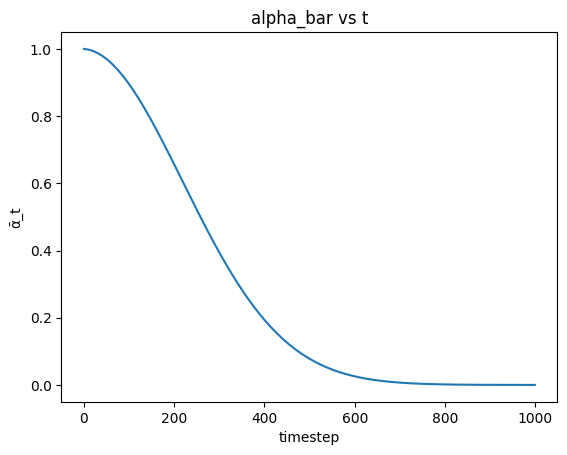

In [9]:
# Visualizar alpha acumulado
plt.plot(alpha_bar.cpu())
plt.title("alpha_bar vs t")
plt.xlabel("timestep")
plt.ylabel("ᾱ_t")
plt.show()

#### **Forward Process (q_sample)**

In [10]:
def q_sample(x0, t, noise):
    t = t.to(x0.device)

    # Extrai sqrt(ᾱ_t) para cada t do batch e adiciona dimensões extras
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)

    # Extrai sqrt(1 - ᾱ_t) de mesmo modo
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1)

    # Retorna sqrt(ᾱ_t) * x0 + sqrt(1 - ᾱ_t) * noise (distribuição q(x_t | x_0))
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

#### **Reverse Process (p_sample_ddpm)**

In [11]:
@torch.no_grad()
def p_sample_conditional(model, x, t, labels, guidance_scale=1.0):
    B = x.shape[0]
    t_tensor = torch.full((B,), t, device=device, dtype=torch.long)

    # Predição condicional
    pred_noise_cond = model(x, t_tensor, labels)

    # Predição incondicional (usando classe especial)
    uncond_labels = torch.full_like(labels, model.num_classes - 1)
    pred_noise_uncond = model(x, t_tensor, uncond_labels)

    # Classifier-free guidance
    pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

    # Parâmetros do processo reverso
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    # Média do posterior
    coeff1 = 1 / torch.sqrt(alpha_t)
    coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = coeff1 * (x - coeff2 * pred_noise)

    # Adição de ruído (exceto no último passo)
    if t > 0:
        alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0)
        posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)
        x_prev = mean + torch.sqrt(posterior_variance) * noise
    else:
        x_prev = mean

    return x_prev

## **Experimentos**

Agora vamos realizar o experimento completo, combinando tudo que aprendemos: treinar nosso modelo condicional enquanto monitoramos continuamente sua performance usando as métricas que implementamos. Este é um ciclo completo de desenvolvimento de modelos generativos.

In [20]:
# Definir Modelo e otimizador
model = ConditionalUNet(
    in_channels=1,
    base_channels=64,
    num_classes=dataset.num_classes + 1,  # +1 para classe "sem condição"
    time_dim=256,
    label_dim=128,
    dropout_prob=0.1
).to(device)

# Loop de Treinamento com Métricas
epochs = 50
eval_frequency = 5  # Avaliar a cada 5 épocas
patience = 25  # Early stopping
no_improve_count = 0
best_loss = float('inf')

# Histórico para salvar métricas
training_history = {
    'epochs': [],
    'train_loss': [],
    'fid_scores': [],
    'lpips_score': [],
    'is_scores': []
}

# Configurar otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scaler = GradScaler()

Durante o treinamento, vamos avaliar periodicamente o modelo usando uma versão das nossas métricas para não tornar o processo muito livre.

In [21]:
def quick_evaluation(model, num_samples=60):
    model.eval()
    generated_samples = []
    sample_labels = []
    samples_per_class = num_samples // dataset.num_classes

    # Métricas TorchMetrics
    fid_metric = TorchMetricsFID(device=device)
    is_metric = TorchMetricsIS(device=device)
    lpips_metric = TorchMetricsLPIPS(device=device)

    with torch.no_grad():
        for class_idx in range(dataset.num_classes):
            for _ in range(samples_per_class):
                x = torch.randn(1, 1, img_size, img_size, device=device)
                label = torch.tensor([class_idx], device=device)

                for t in reversed(range(0, T, 20)):
                    x = p_sample_conditional(model, x, t, label, guidance_scale=3.0)

                generated_samples.append(x.cpu())
                sample_labels.append(class_idx)

    generated_imgs = torch.cat(generated_samples).to(device)

    # Coletar imagens reais
    real_samples = []
    count = 0
    for batch in dataloader:
        real_samples.extend(batch['image'][:5])
        count += len(batch['image'][:5])
        if count >= num_samples:
            break
    real_imgs = torch.stack(real_samples[:num_samples]).to(device)

    # FID requer [0, 1], 299x299, RGB
    fid_metric.update_real(real_imgs)
    fid_metric.update_fake(generated_imgs)
    fid_score = fid_metric.compute()

    # IS também assume [0, 1] + tratamento interno
    is_metric.update(generated_imgs)
    is_mean, _ = is_metric.compute()

    # LPIPS requer [-1, 1] em ambos os tensores
    real_imgs_lpips = torch.clamp(real_imgs, -1, 1)
    generated_imgs_lpips = torch.clamp(generated_imgs, -1, 1)
    lpips_score, _ = lpips_metric.calculate_lpips(real_imgs_lpips, generated_imgs_lpips)

    descriptions = [class_descriptions[label] for label in sample_labels]
    return fid_score, is_mean, lpips_score

In [22]:
# Função para mostrar progresso com geração
def show_and_predict_conditional(model, labels, T, epoch=None):
    model.eval()

    # Inicializar com ruído
    x = torch.randn(1, 1, img_size, img_size, device=device)

    # Processo reverso
    for t in reversed(range(T)):
        x = p_sample_conditional(model, x, t, labels, guidance_scale=3.0)

    # Processar imagem
    img = (x.clamp(-1, 1) + 1) / 2
    img = img[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype('uint8')

    # Visualizar
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    if epoch is not None:
        class_name = dataset.idx_to_label[labels[0].item()]
        ax.text(2, 8, f"Época {epoch}", fontsize=12, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.9))
        ax.text(2, img_size-8, f"Classe: {class_name}", fontsize=10, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.9))

    plt.tight_layout()
    plt.show()

    return img

Implementamos a função de loss que combina o processo forward com a predição do modelo, exatamente como aprendemos ao longo do curso.

In [23]:
def conditional_loss_fn(model, x0, labels, t):
    B = x0.shape[0]
    noise = torch.randn_like(x0)
    x_t = q_sample(x0, t, noise)

    pred_noise = model(x_t, t, labels)
    loss = F.mse_loss(pred_noise, noise)

    return loss

#### **Treinamento do Modelo**

Agora executamos o loop de treinamento completo, monitorando continuamente o progresso e implementando early stopping baseado no FID score.

In [24]:
# Dicionário de Classes
class_descriptions = {
            0: "axial",
            1: "coronal",
            2: "sagittal"
        }

Época 1/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 0:
   Loss: 0.1817
   LR: 0.000100
   FID: 438.948
   IS: 1.146
   LPIPS: 0.770
    Novo melhor modelo salvo! (loss: 0.182)


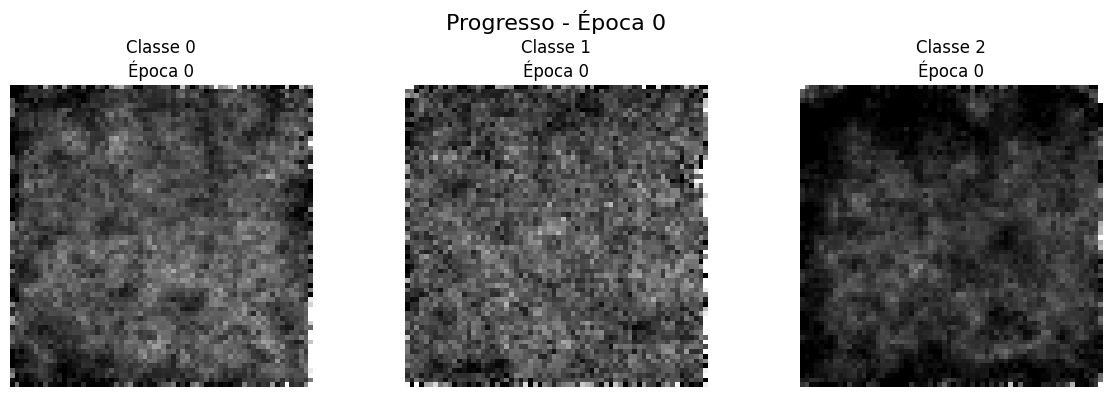

Época 2/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 3/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 4/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 5/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 6/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 5:
   Loss: 0.0423
   LR: 0.000096
   FID: 439.833
   IS: 1.147
   LPIPS: 0.766
    Novo melhor modelo salvo! (loss: 0.042)


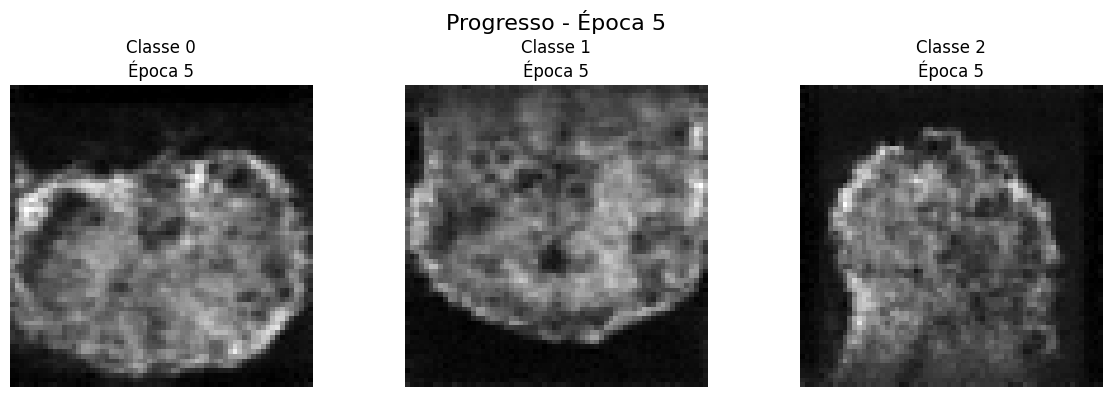

Época 7/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 8/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 9/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 11/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 10:
   Loss: 0.0342
   LR: 0.000089
   FID: 434.009
   IS: 1.150
   LPIPS: 0.765
    Novo melhor modelo salvo! (loss: 0.034)


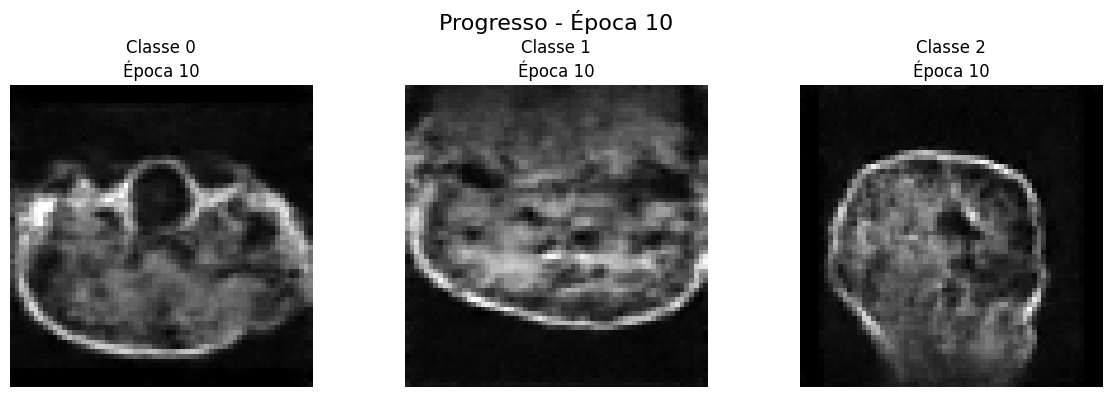

Época 12/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 13/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 14/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 15/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 16/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 15:
   Loss: 0.0320
   LR: 0.000077
   FID: 444.905
   IS: 1.130
   LPIPS: 0.773
    Novo melhor modelo salvo! (loss: 0.032)


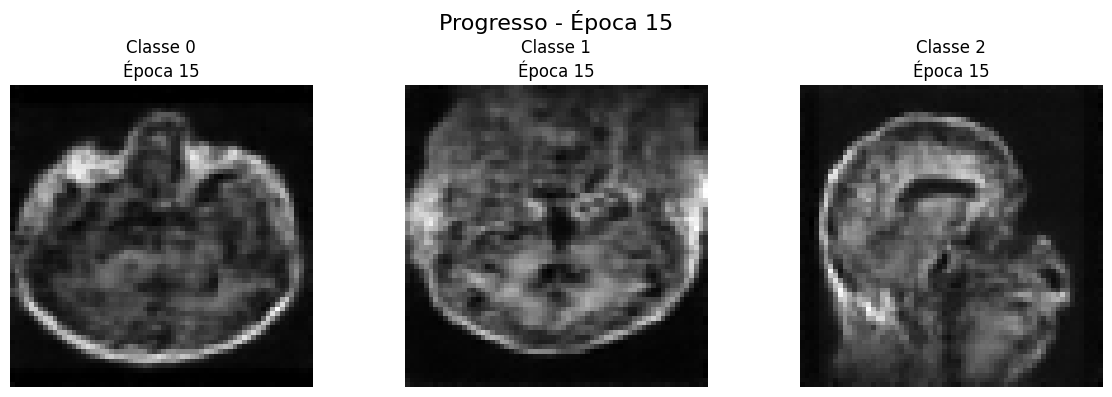

Época 17/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 18/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 19/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 20/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 21/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 20:
   Loss: 0.0295
   LR: 0.000062
   FID: 427.812
   IS: 1.109
   LPIPS: 0.771
    Novo melhor modelo salvo! (loss: 0.030)


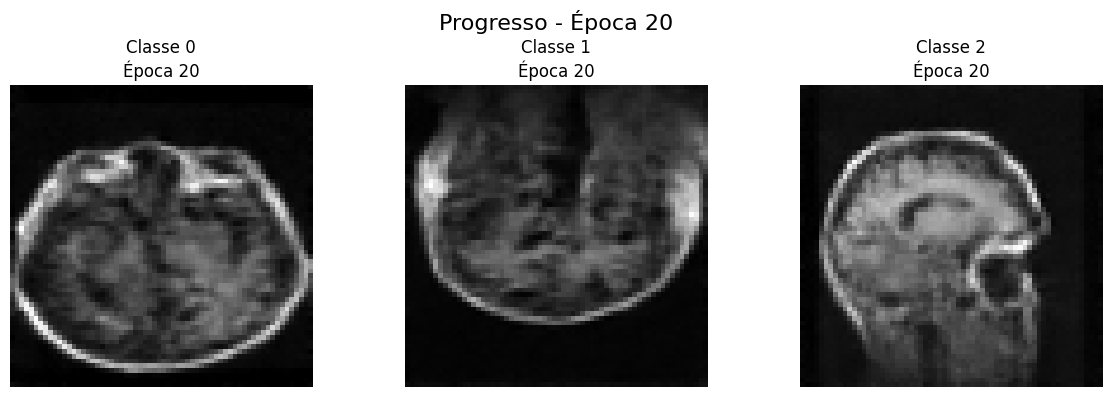

Época 22/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 23/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 24/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 25/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 26/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 25:
   Loss: 0.0298
   LR: 0.000047
   FID: 436.253
   IS: 1.118
   LPIPS: 0.773
    Sem melhoria há 5 épocas


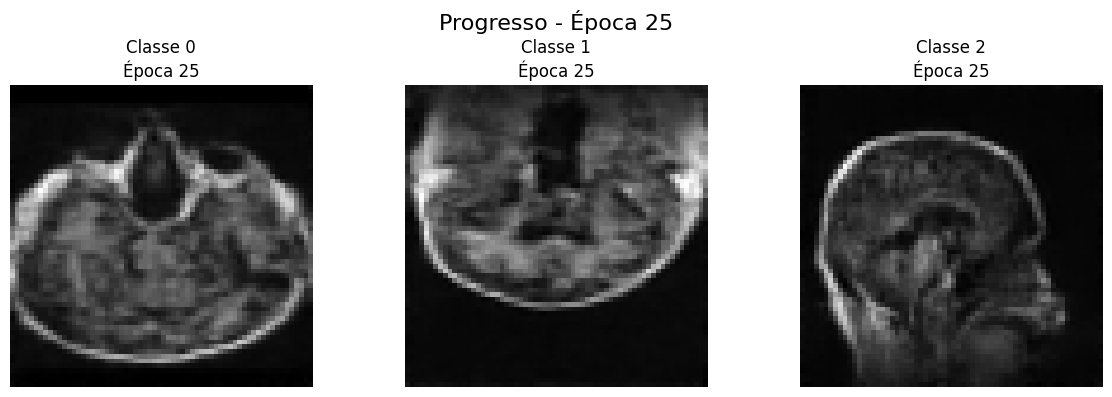

Época 27/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 28/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 29/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 30/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 31/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 30:
   Loss: 0.0295
   LR: 0.000032
   FID: 432.348
   IS: 1.129
   LPIPS: 0.770
    Novo melhor modelo salvo! (loss: 0.030)


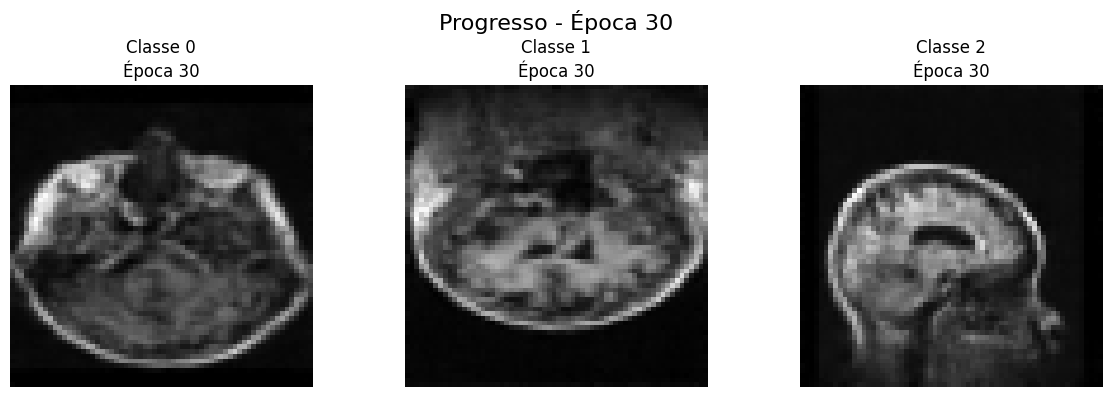

Época 32/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 33/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 34/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 35/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 36/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 35:
   Loss: 0.0268
   LR: 0.000018
   FID: 443.882
   IS: 1.130
   LPIPS: 0.772
    Novo melhor modelo salvo! (loss: 0.027)


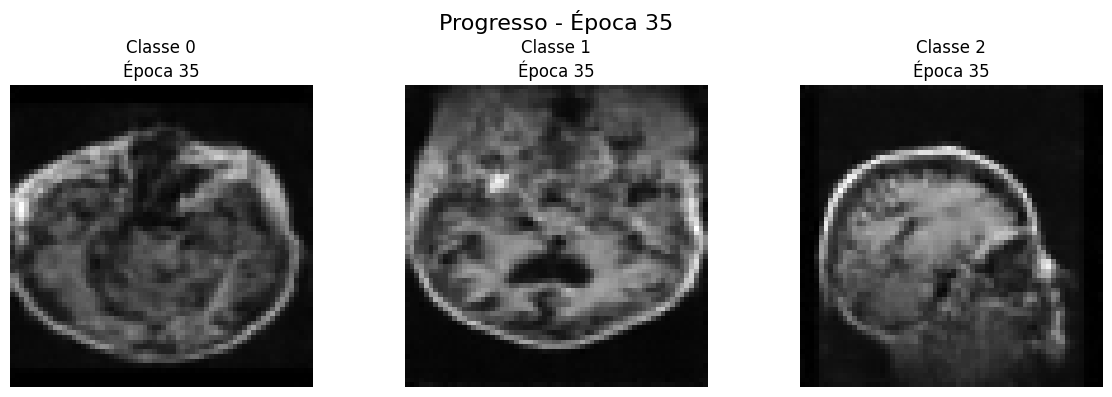

Época 37/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 38/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 39/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 40/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 41/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 40:
   Loss: 0.0274
   LR: 0.000008
   FID: 437.985
   IS: 1.134
   LPIPS: 0.768
    Sem melhoria há 5 épocas


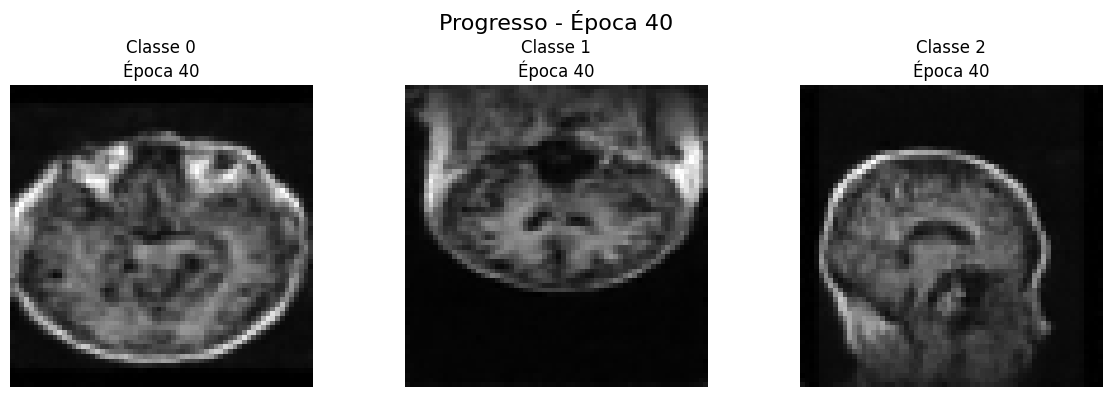

Época 42/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 43/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 44/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 45/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 46/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 45:
   Loss: 0.0272
   LR: 0.000002
   FID: 433.404
   IS: 1.134
   LPIPS: 0.773
    Sem melhoria há 10 épocas


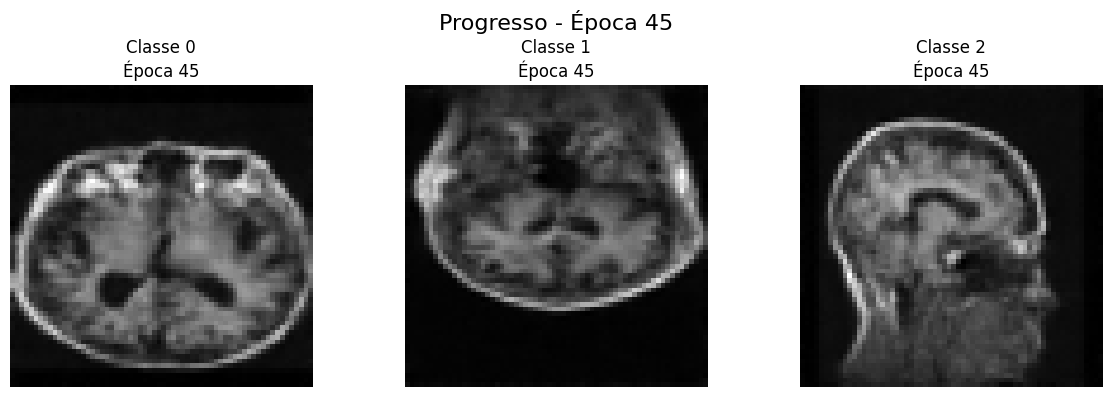

Época 47/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 48/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 49/50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 50/50:   0%|          | 0/61 [00:00<?, ?it/s]


  Época 49:
   Loss: 0.0266
   LR: 0.000000
   FID: 445.014
   IS: 1.159
   LPIPS: 0.772
    Novo melhor modelo salvo! (loss: 0.027)


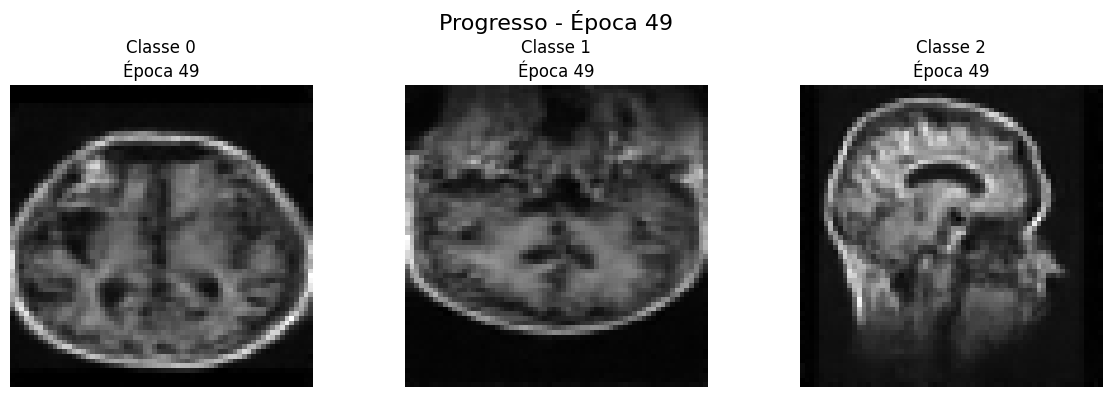


   Treinamento concluído!
   Melhor Loss: 0.027


In [25]:
# Loop de Treinamento
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    # Barra de progresso
    pbar = tqdm(dataloader, desc=f"Época {epoch+1}/{epochs}")



    for batch in pbar:
        optimizer.zero_grad()

        # Dados do batch
        x0 = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Timestep aleatório
        t = torch.randint(0, T, (x0.shape[0],), device=device)

        # Forward pass com mixed precision
        with autocast(device_type='cuda'):
            # Loss de difusão
            noise = torch.randn_like(x0)
            x_t = q_sample(x0, t, noise)
            pred_noise = model(x_t, t, labels)
            loss = F.mse_loss(pred_noise, noise)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        num_batches += 1

        # Atualizar barra de progresso
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Atualizar learning rate
    scheduler.step()

    # Loss média da época
    avg_loss = epoch_loss / num_batches
    training_history['epochs'].append(epoch)
    training_history['train_loss'].append(avg_loss)

    # Avaliação Periódica
    if epoch % eval_frequency == 0 or epoch == epochs - 1:
        print(f"\n  Época {epoch}:")
        print(f"   Loss: {avg_loss:.4f}")
        print(f"   LR: {scheduler.get_last_lr()[0]:.6f}")

        # Calcular métricas
        fid_score, is_score, lpips_score = quick_evaluation(model, num_samples=60)

        if fid_score is not None:
            training_history['fid_scores'].append(fid_score)
            training_history['lpips_score'].append(lpips_score)
            training_history['is_scores'].append(is_score)

            print(f"   FID: {fid_score:.3f}")
            print(f"   IS: {is_score:.3f}")
            print(f"   LPIPS: {lpips_score:.3f}")

            # Early Stopping baseado no FID
            if avg_loss < best_loss:
                best_loss = avg_loss
                no_improve_count = 0

                # Salvar melhor modelo
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_loss': best_loss,
                    'fid_score': fid_score,
                    'is_score': is_score,
                    'lpips_score': lpips_score,
                    'history': training_history
                }, 'conditional_unet_best.pth')

                print(f"    Novo melhor modelo salvo! (loss: {best_loss:.3f})")

            else:
                no_improve_count += eval_frequency
                print(f"    Sem melhoria há {no_improve_count} épocas")

                # Early stopping
                if no_improve_count >= patience:
                    print(f"\n Early stopping após {patience} épocas sem melhoria")
                    break

        # Visualização do Progresso
        model.eval()
        with torch.no_grad():
            fig, axes = plt.subplots(1, dataset.num_classes, figsize=(4*dataset.num_classes, 4))

            for class_idx in range(dataset.num_classes):
                x = torch.randn(1, 1, img_size, img_size, device=device)
                label = torch.tensor([class_idx], device=device)

                # Processo reverso completo para visualização
                for t in reversed(range(T)):
                    x = p_sample_conditional(model, x, t, label, guidance_scale=3.0)

                img_vis = torch.clamp((x[0] * 0.5) + 0.5, 0, 1)
                img_np = img_vis.permute(1, 2, 0).squeeze().cpu().numpy()

                axes[class_idx].imshow(img_np, cmap='gray')
                axes[class_idx].set_title(f'Classe {class_idx}\nÉpoca {epoch}')
                axes[class_idx].axis('off') if dataset.num_classes > 1 else axes.axis('off')

            plt.suptitle(f'Progresso - Época {epoch}', fontsize=16)
            plt.tight_layout()
            plt.show()

        model.train()

print(f"\n   Treinamento concluído!")
print(f"   Melhor Loss: {best_loss:.3f}")

## **Avaliação dos Resultado**

### **Geração de amostras para avaliação dos resultados**

Com o modelo treinado, agora vamos gerar um conjunto maior de amostras para realizar uma avaliação mais robusta e definitiva da qualidade do nosso modelo. Esta etapa é crucial para termos confiança nos resultados antes do deployment.

In [26]:
@torch.no_grad()
def generate_evaluation_samples(model, num_samples=200, guidance_scale=3.0):
    print(f" Gerando {num_samples} amostras para avaliação...")

    model.eval()
    generated_samples = []
    sample_labels = []

    # Dividir amostras igualmente entre classes
    samples_per_class = num_samples // dataset.num_classes

    for class_idx in range(dataset.num_classes):
        class_name = dataset.idx_to_label.get(class_idx, f'classe_{class_idx}')
        print(f"   Gerando {samples_per_class} amostras da classe {class_idx} ({class_name})")

        for i in tqdm(range(samples_per_class), desc=f"Classe {class_idx}"):
            # Ruído inicial
            x = torch.randn(1, 1, img_size, img_size, device=device)
            label = torch.tensor([class_idx], device=device)

            # Processo reverso completo
            for t in reversed(range(T)):
                t_tensor = torch.full((1,), t, device=device, dtype=torch.long)

                # Predição condicional
                pred_noise_cond = model(x, t_tensor, label)

                # Predição incondicional
                uncond_labels = torch.full_like(label, model.num_classes - 1)
                pred_noise_uncond = model(x, t_tensor, uncond_labels)

                # Classifier-free guidance
                pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

                # Parâmetros do processo reverso
                beta_t = betas[t]
                alpha_t = alphas[t]
                alpha_bar_t = alpha_bar[t]

                # Calcular x_{t-1}
                coeff1 = 1 / torch.sqrt(alpha_t)
                coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
                mean = coeff1 * (x - coeff2 * pred_noise)

                if t > 0:
                    alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0)
                    posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
                    noise = torch.randn_like(x)
                    x = mean + torch.sqrt(posterior_variance) * noise
                else:
                    x = mean

            # Armazenar amostra gerada
            generated_samples.append(x.cpu())
            sample_labels.append(class_idx)

    # Converter para tensors
    generated_imgs = torch.cat(generated_samples, dim=0)
    gen_labels = torch.tensor(sample_labels)

    print(f"  {len(generated_imgs)} amostras geradas")
    print(f"   Shape: {generated_imgs.shape}")
    print(f"   Classes: {len(set(sample_labels))}")

    return generated_imgs, gen_labels

# Gerar amostras para avaliação
generated_imgs, gen_labels = generate_evaluation_samples(model, num_samples=200)

 Gerando 200 amostras para avaliação...
   Gerando 66 amostras da classe 0 (y)


Classe 0:   0%|          | 0/66 [00:00<?, ?it/s]

   Gerando 66 amostras da classe 1 (x)


Classe 1:   0%|          | 0/66 [00:00<?, ?it/s]

   Gerando 66 amostras da classe 2 (z)


Classe 2:   0%|          | 0/66 [00:00<?, ?it/s]

  198 amostras geradas
   Shape: torch.Size([198, 1, 64, 64])
   Classes: 3


Para uma avaliação justa, precisamos também de um conjunto representativo de imagens reais do nosso dataset para servir como baseline de comparação.

In [27]:
def collect_real_samples(dataloader, num_samples=200):

    print(f" Coletando {num_samples} amostras reais...")

    real_samples = []
    real_labels_list = []

    # Coletar amostras do dataloader
    collected = 0
    for batch in dataloader:
        images = batch['image']
        labels = batch['label']

        # Adicionar amostras do batch atual
        batch_size = min(len(images), num_samples - collected)

        for i in range(batch_size):
            real_samples.append(images[i].unsqueeze(0))  # Manter dimensão batch
            real_labels_list.append(labels[i].item())
            collected += 1

            if collected >= num_samples:
                break

        if collected >= num_samples:
            break

    # Converter para tensors
    real_imgs = torch.cat(real_samples, dim=0)
    real_labels = torch.tensor(real_labels_list)

    # Estatísticas das amostras coletadas
    unique_classes = set(real_labels_list)
    class_counts = {cls: real_labels_list.count(cls) for cls in unique_classes}

    print(f" {len(real_imgs)} amostras reais coletadas")
    print(f"   Shape: {real_imgs.shape}")
    print(f"   Distribuição por classe:")
    for class_idx, count in class_counts.items():
        class_name = dataset.idx_to_label.get(class_idx, f'classe_{class_idx}')
        print(f"     {class_name}: {count} amostras")

    return real_imgs, real_labels

# Extrair amostras reais
real_imgs, real_labels = collect_real_samples(dataloader, num_samples=198)

 Coletando 198 amostras reais...
 198 amostras reais coletadas
   Shape: torch.Size([198, 1, 64, 64])
   Distribuição por classe:
     y: 59 amostras
     x: 66 amostras
     z: 73 amostras


### **Cálculo das métricas de avaliação**

Agora vamos aplicar todas as métricas que implementamos para obter uma avaliação completa e objetiva da qualidade do nosso modelo treinado.

In [28]:
# Calcular FID
fid_metric = TorchMetricsFID(device=device)

fid_metric.update_real(real_imgs.to(device))
fid_metric.update_fake(generated_imgs.to(device))

fid_score = fid_metric.compute()
print(f"\n FID Score: {fid_score:.3f}")


 FID Score: 134.688


In [29]:
# Calcular Inception Score
is_metric = TorchMetricsIS(device=device)

is_metric.update(generated_imgs.to(device))
is_mean, is_std = is_metric.compute()

print(f"\n Inception Score: {is_mean:.3f} ± {is_std:.3f}")


 Inception Score: 1.666 ± 0.000


In [30]:
# Calcular LPIPS Score
lpips_metric = TorchMetricsLPIPS(device=device)

real_imgs_lpips = torch.clamp(real_imgs, -1, 1).to(device)
generated_imgs_lpips = torch.clamp(generated_imgs, -1, 1).to(device)

lpips_mean, lpips_std = lpips_metric.calculate_lpips(real_imgs_lpips,
                                                     generated_imgs_lpips)
print(f"\n LPIPS Score: {lpips_mean:.3f} ± {lpips_std:.3f}")


 LPIPS Score: 0.435 ± 0.000


Além das métricas quantitativas, é importante também fazer uma avaliação qualitativa visual para entender como nosso modelo está performando.

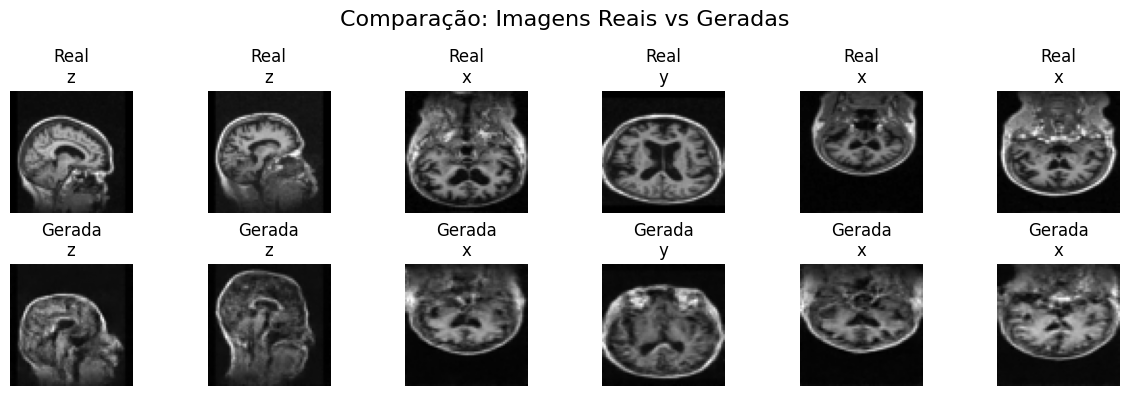

In [31]:
# Visualização lado a lado: Real vs Gerada
fig, axes = plt.subplots(2, 6, figsize=(12, 4))

# Coletar algumas amostras reais
sample_real = []
sample_labels_real = []

for batch in dataloader:
    for img, label in zip(batch['image'], batch['label']):
        if len(sample_real) < 6:
            sample_real.append(img)
            sample_labels_real.append(label.item())
        else:
            break
    if len(sample_real) >= 6:
        break

# Gerar amostras correspondentes
model.eval()
with torch.no_grad():
    for i in range(6):
        # Imagem real
        real_img = sample_real[i]
        real_label = sample_labels_real[i]

        # Processar para visualização ([-1,1] -> [0,1])
        real_vis = torch.clamp((real_img * 0.5) + 0.5, 0, 1)
        real_np = real_vis.permute(1, 2, 0).squeeze().cpu().numpy()

        axes[0, i].imshow(real_np, cmap='gray')
        axes[0, i].set_title(f'Real\n{dataset.idx_to_label.get(real_label, f"classe_{real_label}")}')
        axes[0, i].axis('off')

        # Gerar imagem sintética da mesma classe
        x = torch.randn(1, 1, img_size, img_size, device=device)
        label_tensor = torch.tensor([real_label], device=device)

        for t in reversed(range(T)):
            x = p_sample_conditional(model, x, t, label_tensor, guidance_scale=3.0)

        # Processar para visualização
        gen_vis = torch.clamp((x[0] * 0.5) + 0.5, 0, 1)
        gen_np = gen_vis.permute(1, 2, 0).squeeze().cpu().numpy()

        axes[1, i].imshow(gen_np, cmap='gray')
        axes[1, i].set_title(f'Gerada\n{dataset.idx_to_label.get(real_label, f"classe_{real_label}")}')
        axes[1, i].axis('off')

plt.suptitle('Comparação: Imagens Reais vs Geradas', fontsize=16)
plt.tight_layout()
plt.show()

## **Salvamento e Exportação do Modelo**

Uma das partes mais importantes (e frequentemente negligenciadas) de qualquer projeto de ML é a preparação adequada dos artefatos para uso em produção. Vamos criar uma estrutura completa de MLOps que inclui não apenas o modelo, mas também todos os metadados necessários para reproduzir e deployar nosso trabalho.

In [32]:
# Importar bibliotecas
import json
import pickle
import hashlib
from datetime import datetime
import yaml
import os
import shutil
from pathlib import Path

### **Configurações e Metadado**

In [33]:
# Configurações do modelo (para reprodutibilidade)
model_config = {
    'architecture': 'ConditionalUNet',
    'model_params': {
        'in_channels': 1,
        'base_channels': 64,
        'num_classes': dataset.num_classes + 1,
        'time_dim': 256,
        'label_dim': 128,
        'dropout_prob': 0.1
    },
    'training_params': {
        'epochs': epochs,
        'batch_size': dataloader.batch_size,
        'learning_rate': 1e-4,
        'weight_decay': 1e-5,
        'scheduler': 'CosineAnnealingLR',
        'optimizer': 'AdamW',
        'diffusion_steps': T,
        'beta_start': 1e-4,
        'beta_end': 0.02
    },
    'dataset_info': {
        'name': 'Brain MRI',
        'num_classes': dataset.num_classes,
        'class_mapping': dataset.label_to_idx,
        'image_size': img_size,
        'total_samples': len(dataset)
    }
}

# Metadados do experimento
experiment_metadata = {
    'experiment_id': f"conditional_diffusion_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    'model_version': "v1.0.0",
    'framework': 'PyTorch',
    'python_version': '3.8+',
    'created_by': 'Curso IA Generativa - Aula 09|10',
    'creation_date': datetime.now().isoformat(),
    'git_commit': None,  # Seria preenchido em produção
    'environment': 'training'
}

In [34]:
# Calcular hash do modelo para versionamento
def calculate_model_hash(model_path):
    hash_md5 = hashlib.md5()
    with open(model_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

### **Avaliação Fina Completal**

Antes de salvar, vamos realizar uma avaliação final mais abrangente, incluindo métricas por classe para ter uma visão detalhada do desempenho.

In [35]:
# Carregar o melhor modelo
best_checkpoint = torch.load('conditional_unet_best.pth', map_location=device, weights_only=False)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.eval()

# Avaliação final com mais amostras
final_evaluation = {}

# Gerar amostras para avaliação final
print("   Gerando amostras finais...")
generated_imgs_final, gen_labels_final = generated_imgs, gen_labels #generate_evaluation_samples(model, num_samples=200) #
real_imgs_final, real_labels_final = real_imgs, real_labels #collect_real_samples(dataloader, num_samples=200) #

# Métricas finais
print("   Calculando métricas finais...")

# FID
fid_metric = TorchMetricsFID(device=device)
fid_metric.update_real(real_imgs_final.to(device))
fid_metric.update_fake(generated_imgs_final.to(device))
final_fid = fid_metric.compute()

# IS
is_metric = TorchMetricsIS(device=device)
is_metric.update(generated_imgs_final.to(device))
final_is_mean, final_is_std = is_metric.compute()

# Métricas por classe
final_class_metrics = {}
for class_idx in range(dataset.num_classes):
    class_mask = gen_labels_final == class_idx
    real_mask = real_labels_final == class_idx

    if class_mask.sum() > 0 and real_mask.sum() > 0:
        class_gen = generated_imgs_final[class_mask]
        class_real = real_imgs_final[real_mask]

        fid_metric.update_real(class_real.to(device))
        fid_metric.update_fake(class_gen.to(device))
        class_fid = fid_metric.compute()

        class_name = dataset.idx_to_label.get(class_idx, f'classe_{class_idx}')
        final_class_metrics[class_name] = {
            'fid': float(class_fid),
            'samples_generated': int(class_mask.sum()),
            'samples_real': int(real_mask.sum())
        }

# Compilar resultados finais
final_evaluation = {
    'overall_metrics': {
        'fid_score': float(final_fid),
        'inception_score_mean': float(final_is_mean),
        'inception_score_std': float(final_is_std),
    },
    'class_metrics': final_class_metrics,
    'evaluation_samples': {
        'generated': int(len(generated_imgs_final)),
        'real': int(len(real_imgs_final))
    },
    'evaluation_date': datetime.now().isoformat()
}

print(f"    FID Final: {final_fid:.3f}")
print(f"    IS Final: {final_is_mean:.3f} ± {final_is_std:.3f}")

   Gerando amostras finais...
   Calculando métricas finais...
    FID Final: 134.688
    IS Final: 1.676 ± 0.000


### **Criar Estrutura de Arquivos**

Agora vamos criar uma estrutura de artefatos de MLOps, organizando todos os componentes do nosso projeto de forma clara e reproduzível.

```
├──model_artifacts_<experiment_id>/
├──── models/         # Modelos treinados e versões salvas (e.g., .pkl, .h5, .pt)
├────configs/        # Configurações do experimento (e.g., JSON, YAML, parâmetros)
├──── metrics/        # Métricas de avaliação dos modelos (e.g., JSON, CSV, gráficos)
├──── logs/           # Logs de execução e treinamento
├──── samples/        # Amostras de entrada e saída dos modelos (e.g., previsões)
├──── docs/           # Documentação complementar ou artefatos explicativos
```

In [36]:
# Criar estrutura de diretórios
base_dir = Path(f"model_artifacts_{experiment_metadata['experiment_id']}")
base_dir.mkdir(exist_ok=True)

# Subdiretórios
(base_dir / "models").mkdir(exist_ok=True)
(base_dir / "configs").mkdir(exist_ok=True)
(base_dir / "metrics").mkdir(exist_ok=True)
(base_dir / "logs").mkdir(exist_ok=True)
(base_dir / "samples").mkdir(exist_ok=True)
(base_dir / "docs").mkdir(exist_ok=True)

print(f"   Estrutura criada em: {base_dir}")

   Estrutura criada em: model_artifacts_conditional_diffusion_20250729_163646


### **Salvamento dos artefatos do modelo**

Vamos salvar nosso modelo de diferentes formas para atender diferentes necessidades de deployment e reutilização.

In [37]:
# Salvar Modelo principal (PyTorch)
model_path = base_dir / "models" / "conditional_unet_final.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'experiment_metadata': experiment_metadata,
    'training_history': training_history,
    'final_evaluation': final_evaluation,
    'class_descriptions': class_descriptions,
    'diffusion_params': {
        'betas': betas.cpu(),
        'alphas': alphas.cpu(),
        'alpha_bar': alpha_bar.cpu(),
        'T': T
    }
}, model_path)

# Salvar Modelo para inferência (apenas weights)
inference_model_path = base_dir / "models" / "model_weights_only.pth"
torch.save(model.state_dict(), inference_model_path)

# Salvar Configurações
with open(base_dir / "configs" / "model_config.json", 'w') as f:
    json.dump(model_config, f, indent=2)

with open(base_dir / "configs" / "experiment_metadata.json", 'w') as f:
    json.dump(experiment_metadata, f, indent=2)

# Salvar Dataset info
dataset_info = {
    'class_mapping': dataset.label_to_idx,
    'idx_to_label': dataset.idx_to_label,
    'num_classes': dataset.num_classes,
    'preprocessing': {
        'resize': img_size,
        'normalize_mean': 0.5,
        'normalize_std': 0.5,
        'range': '[-1, 1]'
    }
}

with open(base_dir / "configs" / "dataset_config.json", 'w') as f:
    json.dump(dataset_info, f, indent=2)

### **Salvamento de métricas e logs**

E também realizar o salvamento das métricas e logs de desempenho do modelo e o processo de treinamento para auditoria e reprodutibilidade.

In [38]:
# Salvar métricas finais
with open(base_dir / "metrics" / "final_evaluation.json", 'w') as f:
    json.dump(final_evaluation, f, indent=2)

# Salvar histórico de treinamento
training_history = json.loads(json.dumps(training_history, default=lambda o: float(o) if isinstance(o, np.float32) else o))
with open(base_dir / "metrics" / "training_history.json", 'w') as f:
    json.dump(training_history, f, indent=2)

# Log estruturado
training_log = {
    'experiment_id': experiment_metadata['experiment_id'],
    'start_time': experiment_metadata['creation_date'],
    'end_time': datetime.now().isoformat(),
    'status': 'completed',
    'final_metrics': final_evaluation.get('overall_metrics', {}),
    'model_path': str(model_path),
    'artifacts_directory': str(base_dir)
}

with open(base_dir / "logs" / "training_log.json", 'w') as f:
    json.dump(training_log, f, indent=2)

### **Gerando amostras de demonstração**

Para facilitar a avaliação visual do modelo, vamos gerar algumas amostras de cada classe e salvá-las como imagens PNG.

In [39]:
from PIL import Image

model.eval()
demo_samples = {}

with torch.no_grad():
    for class_idx in range(dataset.num_classes):
        class_samples = []
        class_name = dataset.idx_to_label.get(class_idx, f'classe_{class_idx}')

        # Gerar 5 amostras por classe
        for i in range(5):
            x = torch.randn(1, 1, img_size, img_size, device=device)
            label = torch.tensor([class_idx], device=device)

            for t in reversed(range(T)):
                x = p_sample_conditional(model, x, t, label, guidance_scale=3.0)

            # Converter para imagem
            img_vis = torch.clamp((x[0] * 0.5) + 0.5, 0, 1)
            img_np = (img_vis.permute(1, 2, 0).squeeze().cpu().numpy() * 255).astype('uint8')

            # Salvar imagem
            sample_path = base_dir / "samples" / f"{class_name}_sample_{i+1}.png"
            Image.fromarray(img_np, mode='L').save(sample_path)

            class_samples.append(str(sample_path))

        demo_samples[class_name] = class_samples

# Salvar info das amostras
with open(base_dir / "samples" / "demo_samples.json", 'w') as f:
    json.dump(demo_samples, f, indent=2)

/tmp/ipython-input-39-3958799570.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img_np, mode='L').save(sample_path)


### **Salvando Documentação**

Para completar nosso pacote de artefatos, vamos criar documentação clara que explique como usar e interpretar nosso modelo.

In [44]:
readme_content = f"""# Modelo de Difusão Condicional - {experiment_metadata['experiment_id']}

## Visão Geral
Modelo de difusão condicional treinado para geração de imagens de ressonância magnética cerebral.

## Arquitetura
- **Modelo**: ConditionalUNet
- **Parâmetros**: {sum(p.numel() for p in model.parameters()):,}
- **Classes**: {dataset.num_classes} ({', '.join(dataset.label_to_idx.keys())})
- **Resolução**: {img_size}x{img_size}

## Métricas Finais
- **FID Score**: {final_evaluation.get('overall_metrics', {}).get('fid_score', 'N/A')}
- **Inception Score**: {final_evaluation.get('overall_metrics', {}).get('inception_score_mean', 'N/A')}

## Arquivos
- `models/conditional_unet_final.pth` - Modelo completo
- `models/model_weights_only.pth` - Apenas pesos (para inferência)
- `models/conditional_unet.pth` - Modelo OPTH (deployment)
- `configs/` - Configurações do modelo e dataset
- `metrics/` - Métricas de avaliação
- `samples/` - Amostras de demonstração
"""

# Escrita segura do arquivo documentation.md
readme_path = base_dir / "docs" / "documentation.md"

with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

# **Sistema de Inferência Completo**

Agora que temos todos os artefatos salvos adequadamente, vamos criar um sistema completo de inferência que pode ser usado independentemente do código de treinamento. Este sistema simula como nosso modelo seria usado em produção.

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import json
from datetime import datetime

device ='cuda'

In [15]:
#Carregar Dataset
dataset_config = '/content/model_artifacts_conditional_diffusion_20250729_163646/configs/dataset_config.json'
with open(dataset_config, 'r') as file:
    dataset_config = json.load(file)

# Carregar modelo salvo
checkpoint_path = '/content/model_artifacts_conditional_diffusion_20250729_163646/models/conditional_unet_final.pth'

print(f"Carregando modelo: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Recriar modelo com configurações salvas
model_inference = ConditionalUNet(
    in_channels=1,
    base_channels=64,
    num_classes=dataset_config['num_classes'] +1,
    time_dim=256,
    label_dim=128,
    dropout_prob=0.1
).to(device)

model_inference.load_state_dict(checkpoint['model_state_dict'])
model_inference.eval()

Carregando modelo: /content/model_artifacts_conditional_diffusion_20250729_163646/models/conditional_unet_final.pth


ConditionalUNet(
  (label_embedding): LabelEmbedding(
    (embedding): Embedding(4, 128)
  )
  (time_embedding): ConditionalTimeEmbedding(
    (time_mlp): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (label_mlp): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (fusion): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): SiLU()
    )
  )
  (down1): ConditionalDown(
    (block1): ConditionalResidualBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (act1): SiLU()
      (time_proj): Linear(in_features=256, out_features=64, bias=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

Vamos criar uma função para gerar imagens, que pode ser facilmente integrada em aplicações maiores.

In [16]:
@torch.no_grad()
def p_sample_conditional(model, x, t, labels, guidance_scale=1.0):
    B = x.shape[0]
    t_tensor = torch.full((B,), t, device=device, dtype=torch.long)

    # Predição condicional
    pred_noise_cond = model(x, t_tensor, labels)

    # Predição incondicional (usando classe especial)
    uncond_labels = torch.full_like(labels, model.num_classes - 1)
    pred_noise_uncond = model(x, t_tensor, uncond_labels)

    # Classifier-free guidance
    pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

    # Parâmetros do processo reverso
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    # Média do posterior
    coeff1 = 1 / torch.sqrt(alpha_t)
    coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = coeff1 * (x - coeff2 * pred_noise)

    # Adição de ruído (exceto no último passo)
    if t > 0:
        alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0)
        posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)
        x_prev = mean + torch.sqrt(posterior_variance) * noise
    else:
        x_prev = mean

    return x_prev

In [20]:
def generate_and_save_image(class_idx, guidance_scale=3.0, seed=None, save_dir="generated_images"):

    # Configurar seed se fornecido
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    # Criar diretório se não existir
    Path(save_dir).mkdir(exist_ok=True)

    # Ruído inicial
    img_size = dataset_config['preprocessing']['resize']
    x = torch.randn(1, 1, img_size, img_size, device=device)
    label = torch.tensor([class_idx], device=device)

    class_name = dataset_config['idx_to_label'].get(class_idx, f'classe_{class_idx}')
    print(f"Gerando imagem: {class_name}")

    # Processo reverso
    for t in tqdm(reversed(range(T)), desc="Gerando"):
        x = p_sample_conditional(model_inference, x, t, label, guidance_scale=guidance_scale)

    # Processar imagem final
    img = torch.clamp((x[0] * 0.5) + 0.5, 0, 1)
    img_np = img.permute(1, 2, 0).squeeze().cpu().numpy()

    # Criar nome do arquivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    seed_str = f"_seed{seed}" if seed else ""
    filename = f"{save_dir}/{class_name}_{timestamp}{seed_str}.png"

    # Salvar como PNG
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8), mode='L')
    img_pil.save(filename)

    # Mostrar imagem
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np, cmap='gray')
    plt.title(f'{class_name}\nGuidance: {guidance_scale}' + (f', Seed: {seed}' if seed else ''))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Imagem salva: {filename}")
    return filename, img_np

Para facilitar o uso do modelo, vamos criar algumas funções que automatizam tarefas comuns.

In [23]:
def generate_all_classes(guidance_scale=3.0):
    print(f"Classes disponíveis: {list(dataset_config['idx_to_label'].values())}")

    generated_files = []

    for class_idx in range(dataset_config['num_classes']):
        filename, img = generate_and_save_image(
            class_idx=class_idx,
            guidance_scale=guidance_scale,
            seed=42 + class_idx  # Seed determinístico
        )
        generated_files.append(filename)

    print(f"\n {len(generated_files)} imagens geradas!")
    return generated_files

def generate_multiple_images(class_idx, num_images=5, guidance_scale=3.0):

    class_name = dataset_config['idx_to_label'].get(class_idx, f'classe_{class_idx}')
    print(f"\n Gerando {num_images} Imagens da Classe: {class_name}")

    # Criar grid de visualização
    cols = min(num_images, 5)
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if num_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()

    generated_files = []

    for i in range(num_images):
        filename, img = generate_and_save_image(
            class_idx=class_idx,
            guidance_scale=guidance_scale,
            seed=100 + i
        )
        generated_files.append(filename)

        # Adicionar ao grid
        if i < len(axes):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{class_name} #{i+1}')
            axes[i].axis('off')

    # Ocultar eixos extras
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'{num_images} Imagens Geradas - {class_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\n {len(generated_files)} imagens da classe '{class_name}' geradas!")
    return generated_files

Para finalizar, vamos criar uma interface simples que permite aos usuários interagir facilmente com nosso modelo treinado.

In [21]:
def interface():
    print(" Modelo de Difusão Condicional")
    print("\n Classes disponíveis:")
    for idx, name in dataset_config['idx_to_label'].items():
        print(f"   {idx}: {name}")

    while True:
        print("\n" + "-"*30)
        print("1. Gerar uma imagem de cada classe")
        print("2. Gerar múltiplas imagens de uma classe")
        print("3. Gerar uma imagem específica")
        print("4. Sair")

        choice = input("\nEscolha (1-4): ").strip()

        if choice == '1':
            guidance = float(input("Guidance scale (padrão 3.0): ") or "3.0")
            generate_all_classes(guidance)

        elif choice == '2':
            class_idx = int(input(f"Classe (0-{dataset_config['num_classes']-1}): "))
            num_imgs = int(input("Quantas imagens (padrão 5): ") or "5")
            guidance = float(input("Guidance scale (padrão 3.0): ") or "3.0")

            if 0 <= class_idx < dataset_config['num_classes']:
                generate_multiple_images(class_idx, num_imgs, guidance)
            else:
                print(" Classe inválida!")

        elif choice == '3':
            class_idx = int(input(f"Classe (0-{dataset_config['num_classes']-1}): "))
            guidance = float(input("Guidance scale (padrão 3.0): ") or "3.0")
            seed_input = input("Seed (opcional): ").strip()
            seed = int(seed_input) if seed_input else None

            if 0 <= class_idx < dataset_config['num_classes']:
                generate_and_save_image(class_idx, guidance, seed)
            else:
                print(" Classe inválida!")

        elif choice == '4':
            print(" Processo finalizado")
            break

        else:
            print(" Opção inválida!")


 Abrir interface interativa? (s/n): s
 Modelo de Difusão Condicional

 Classes disponíveis:
   0: y
   1: x
   2: z

------------------------------
1. Gerar uma imagem de cada classe
2. Gerar múltiplas imagens de uma classe
3. Gerar uma imagem específica
4. Sair

Escolha (1-4): 2
Classe (0-2): 1
Quantas imagens (padrão 5): 2
Guidance scale (padrão 3.0): 3.0

 Gerando 2 Imagens da Classe: classe_1
Gerando imagem: classe_1


Gerando: 0it [00:00, ?it/s]

/tmp/ipython-input-20-131254848.py:34: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray((img_np * 255).astype(np.uint8), mode='L')


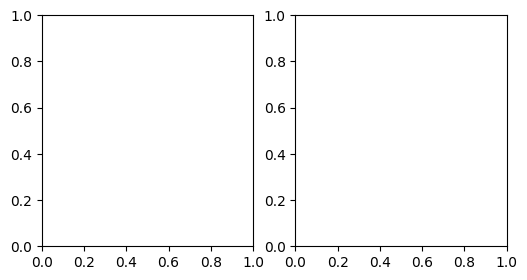

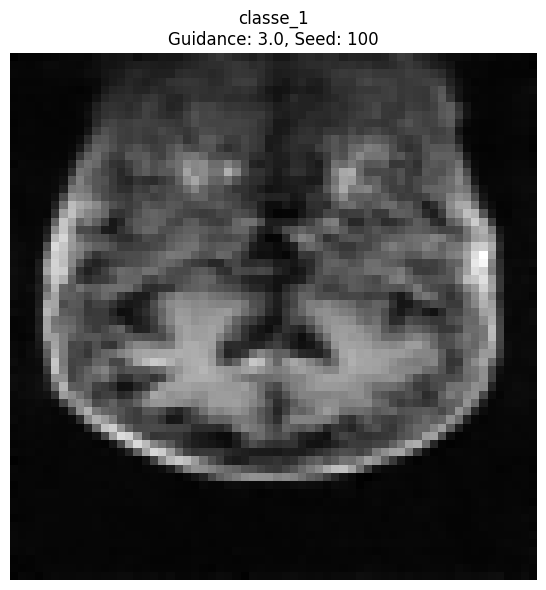

Imagem salva: generated_images/classe_1_20250729_192356_seed100.png
Gerando imagem: classe_1


Gerando: 0it [00:00, ?it/s]

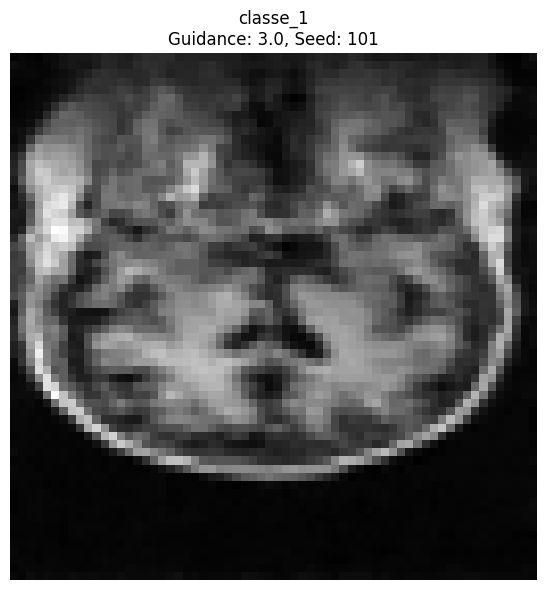

Imagem salva: generated_images/classe_1_20250729_192420_seed101.png


<Figure size 640x480 with 0 Axes>


 2 imagens da classe 'classe_1' geradas!

------------------------------
1. Gerar uma imagem de cada classe
2. Gerar múltiplas imagens de uma classe
3. Gerar uma imagem específica
4. Sair

Escolha (1-4): 1
Guidance scale (padrão 3.0): 3.0
Classes disponíveis: ['y', 'x', 'z']
Gerando imagem: classe_0


Gerando: 0it [00:00, ?it/s]

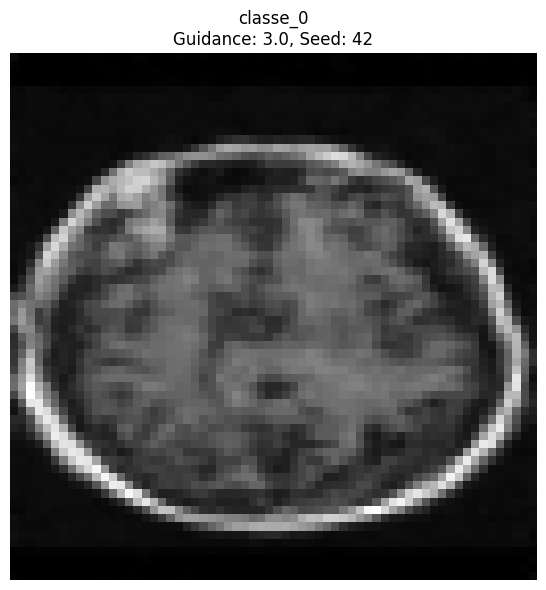

Imagem salva: generated_images/classe_0_20250729_192503_seed42.png
Gerando imagem: classe_1


Gerando: 0it [00:00, ?it/s]

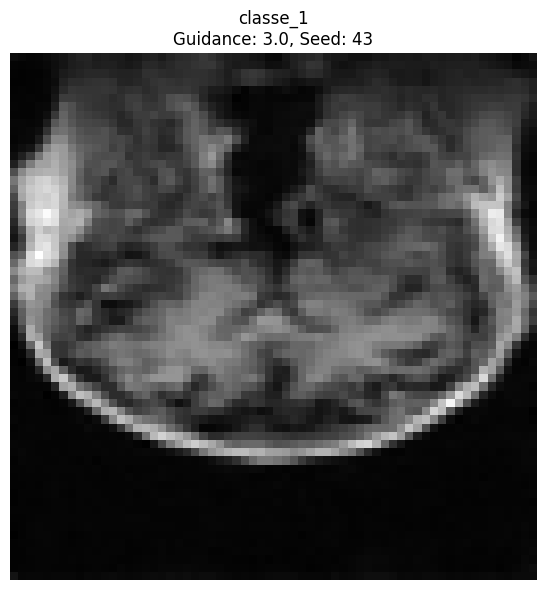

Imagem salva: generated_images/classe_1_20250729_192526_seed43.png
Gerando imagem: classe_2


Gerando: 0it [00:00, ?it/s]

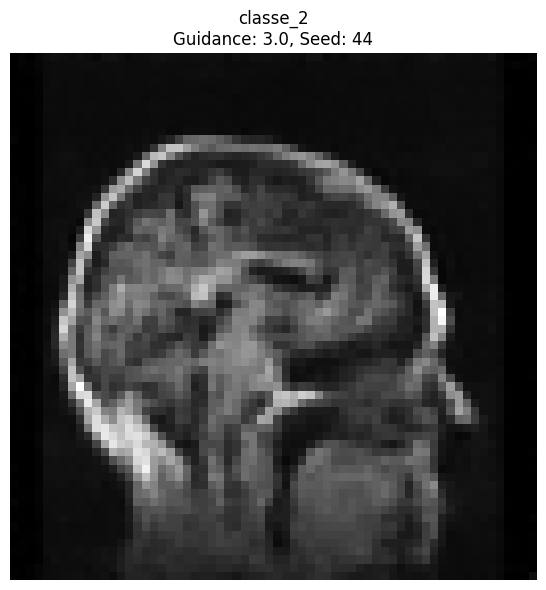

Imagem salva: generated_images/classe_2_20250729_192549_seed44.png

 3 imagens geradas!

------------------------------
1. Gerar uma imagem de cada classe
2. Gerar múltiplas imagens de uma classe
3. Gerar uma imagem específica
4. Sair


In [ ]:
continue_choice = input("\n Abrir interface interativa? (s/n): ").lower()
interface()